In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier # XGBoost se importa aparte
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings

# Ignorar advertencias, útil para la presentación
warnings.filterwarnings('ignore')

# Configuración para visualizaciones
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# Semilla para reproducibilidad
np.random.seed(42)

print("Librerías cargadas.")

# --- 1.1 Generación del Dataset Sintético ---
n_samples = 1500

# Variables Numéricas
edad = np.random.randint(20, 80, n_samples)
peso_kg = np.random.normal(70, 15, n_samples) # Media 70kg, Desv. 15kg
altura_cm = np.random.normal(170, 10, n_samples) # Media 170cm, Desv. 10cm
presion_sistolica = np.random.normal(120, 15, n_samples)
presion_diastolica = np.random.normal(80, 10, n_samples)
colesterol_total = np.random.normal(200, 40, n_samples)
glucosa_ayuno = np.random.normal(90, 20, n_samples)
nivel_actividad_fisica_hrs_sem = np.random.uniform(0, 10, n_samples)
consumo_alcohol_unidades_sem = np.random.uniform(0, 20, n_samples)
num_visitas_medico_ult_año = np.random.randint(0, 8, n_samples)
historial_familiar_enfermedad_x_score = np.random.uniform(0, 10, n_samples)

# Inyectar algunos outliers en variables numéricas
# Edad extrema
edad[np.random.choice(n_samples, 10, replace=False)] = np.random.randint(85, 95, 10)
# Presión sistólica muy alta
presion_sistolica[np.random.choice(n_samples, 15, replace=False)] = np.random.normal(180, 10, 15)
# Glucosa muy alta
glucosa_ayuno[np.random.choice(n_samples, 15, replace=False)] = np.random.normal(250, 30, 15)
# Colesterol muy alto
colesterol_total[np.random.choice(n_samples, 15, replace=False)] = np.random.normal(300, 50, 15)


# Variables Categóricas
genero = np.random.choice(['Masculino', 'Femenino', 'No binario'], n_samples, p=[0.49, 0.49, 0.02])
fumador = np.random.choice(['Sí', 'No', 'Ex-Fumador'], n_samples, p=[0.25, 0.60, 0.15])
dieta = np.random.choice(['Vegetariana', 'Mediterránea', 'Estándar', 'Pescetariana'], n_samples, p=[0.1, 0.2, 0.6, 0.1])
estres_nivel = np.random.choice(['Bajo', 'Medio', 'Alto'], n_samples, p=[0.4, 0.4, 0.2])
grupo_sanguineo = np.random.choice(['A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'O+', 'O-'], n_samples, p=[0.34, 0.06, 0.09, 0.02, 0.04, 0.01, 0.4, 0.04])
sintoma_dolor_cabeza = np.random.choice(['Sí', 'No'], n_samples, p=[0.3, 0.7])
sintoma_fatiga = np.random.choice(['Sí', 'No'], n_samples, p=[0.4, 0.6])
sintoma_nauseas = np.random.choice(['Sí', 'No'], n_samples, p=[0.15, 0.85])


# Variables de Fecha/Hora
fecha_actual = pd.to_datetime('2025-01-01')
fecha_ultima_revision = fecha_actual - pd.to_timedelta(np.random.randint(1, 365*5, n_samples), unit='D') # Últimos 5 años

# Crear DataFrame
data = pd.DataFrame({
    'ID_Paciente': range(1, n_samples + 1),
    'Edad': edad,
    'Peso_KG': peso_kg,
    'Altura_CM': altura_cm,
    'Presion_Sistolica': presion_sistolica,
    'Presion_Diastolica': presion_diastolica,
    'Colesterol_Total': colesterol_total,
    'Glucosa_Ayuno': glucosa_ayuno,
    'Nivel_Actividad_Fisica_Hrs_Sem': nivel_actividad_fisica_hrs_sem,
    'Consumo_Alcohol_Unidades_Sem': consumo_alcohol_unidades_sem,
    'Num_Visitas_Medico_Ult_Año': num_visitas_medico_ult_año,
    'Historial_Familiar_Enfermedad_X_Score': historial_familiar_enfermedad_x_score,
    'Genero': genero,
    'Fumador': fumador,
    'Dieta': dieta,
    'Estres_Nivel': estres_nivel,
    'Grupo_Sanguineo': grupo_sanguineo,
    'Sintoma_Dolor_Cabeza': sintoma_dolor_cabeza,
    'Sintoma_Fatiga': sintoma_fatiga,
    'Sintoma_Nauseas': sintoma_nauseas,
    'Fecha_Ultima_Revision': fecha_ultima_revision
})

# Calcular IMC
data['IMC'] = data['Peso_KG'] / ((data['Altura_CM'] / 100)**2)

# Inyectar valores nulos aleatoriamente (aprox. 3-5% de nulos en algunas columnas)
for col in ['Peso_KG', 'Presion_Sistolica', 'Colesterol_Total', 'Fumador', 'Dieta', 'IMC', 'Nivel_Actividad_Fisica_Hrs_Sem', 'Fecha_Ultima_Revision']:
    data.loc[np.random.choice(n_samples, int(n_samples * 0.04), replace=False), col] = np.nan

# --- Generación de la Variable Objetivo 'Enfermedad_X' (0 o 1) ---
# Creamos una probabilidad base y la ajustamos con factores de riesgo
data['prob_enfermedad_x'] = (
    0.05 + # Probabilidad base
    (data['Edad'] / 80) * 0.2 + # La edad aumenta la probabilidad
    (data['IMC'] > 30) * 0.15 + # IMC alto aumenta la probabilidad
    (data['Presion_Sistolica'] > 140) * 0.1 + # Presión alta aumenta la probabilidad
    (data['Colesterol_Total'] > 240) * 0.08 + # Colesterol alto
    (data['Glucosa_Ayuno'] > 120) * 0.12 + # Glucosa alta
    (data['Fumador'] == 'Sí') * 0.15 + # Fumar
    (data['Estres_Nivel'] == 'Alto') * 0.05 + # Estrés
    (data['Historial_Familiar_Enfermedad_X_Score'] / 10) * 0.1 + # Historial familiar
    (data['Sintoma_Fatiga'] == 'Sí') * 0.07 + # Fatiga
    np.random.normal(0, 0.05, n_samples) # Ruido aleatorio
)

# Ajustar la probabilidad para que esté entre 0 y 1
data['prob_enfermedad_x'] = np.clip(data['prob_enfermedad_x'], 0.01, 0.99)

# Convertir probabilidad a clase binaria (ej. si prob > 0.5, entonces 1)
# Ajustaremos el umbral para obtener un cierto desbalance
threshold = 0.4 # Intentar un umbral para que haya más casos de la enfermedad (desbalance controlado)
data['Enfermedad_X'] = (data['prob_enfermedad_x'] > threshold).astype(int)

# Asegurar un desbalance razonable, por ejemplo, 30-40% con enfermedad
desired_disease_ratio = 0.35 # Queremos que el 35% tenga la enfermedad
current_disease_ratio = data['Enfermedad_X'].mean()

if current_disease_ratio < desired_disease_ratio:
    num_to_flip = int(n_samples * desired_disease_ratio) - data['Enfermedad_X'].sum()
    if num_to_flip > 0:
        # Seleccionar aleatoriamente casos sin enfermedad y alta probabilidad para cambiar
        potential_flips = data[(data['Enfermedad_X'] == 0) & (data['prob_enfermedad_x'] > 0.3)].index
        if len(potential_flips) > num_to_flip:
            flip_indices = np.random.choice(potential_flips, num_to_flip, replace=False)
            data.loc[flip_indices, 'Enfermedad_X'] = 1
        elif len(potential_flips) > 0: # Si no hay suficientes, cambiar todos los posibles
            data.loc[potential_flips, 'Enfermedad_X'] = 1
elif current_disease_ratio > desired_disease_ratio:
    num_to_flip = data['Enfermedad_X'].sum() - int(n_samples * desired_disease_ratio)
    if num_to_flip > 0:
        # Seleccionar aleatoriamente casos con enfermedad y baja probabilidad para cambiar
        potential_flips = data[(data['Enfermedad_X'] == 1) & (data['prob_enfermedad_x'] < 0.6)].index
        if len(potential_flips) > num_to_flip:
            flip_indices = np.random.choice(potential_flips, num_to_flip, replace=False)
            data.loc[flip_indices, 'Enfermedad_X'] = 0
        elif len(potential_flips) > 0:
            data.loc[potential_flips, 'Enfermedad_X'] = 0

# Eliminar la columna de probabilidad si no es necesaria para el análisis
data = data.drop(columns=['prob_enfermedad_x'])

print(f"Dataset sintético generado con {data.shape[0]} filas y {data.shape[1]} columnas.")
print("\nPrimeras 5 filas del dataset:")
print(data.head())
print(f"\nDistribución de la variable objetivo 'Enfermedad_X':\n{data['Enfermedad_X'].value_counts(normalize=True)}")
print("\nEstado de nulos en el dataset:")
print(data.isnull().sum()[data.isnull().sum() > 0])

Librerías cargadas.
Dataset sintético generado con 1500 filas y 23 columnas.

Primeras 5 filas del dataset:
   ID_Paciente  Edad    Peso_KG   Altura_CM  Presion_Sistolica  \
0            1    58  63.963233  175.198649         108.708670   
1            2    71        NaN  189.436030         108.167452   
2            3    48  62.898607  173.712129         114.115185   
3            4    34  84.278245  181.532386         117.384055   
4            5    62  54.180447  160.656484         107.521781   

   Presion_Diastolica  Colesterol_Total  Glucosa_Ayuno  \
0           82.523742        248.917942      52.758211   
1           84.478633        164.298616     109.654539   
2           76.611251        178.635976     100.457626   
3           81.899909        208.444969     101.878975   
4           89.521837        133.249402      66.156985   

   Nivel_Actividad_Fisica_Hrs_Sem  Consumo_Alcohol_Unidades_Sem  ...  \
0                        8.095873                     17.705982  ...   
1 


--- 2.1 Información General del Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   ID_Paciente                            1500 non-null   int64         
 1   Edad                                   1500 non-null   int32         
 2   Peso_KG                                1440 non-null   float64       
 3   Altura_CM                              1500 non-null   float64       
 4   Presion_Sistolica                      1440 non-null   float64       
 5   Presion_Diastolica                     1500 non-null   float64       
 6   Colesterol_Total                       1440 non-null   float64       
 7   Glucosa_Ayuno                          1500 non-null   float64       
 8   Nivel_Actividad_Fisica_Hrs_Sem         1440 non-null   float64       
 9   Consumo_Alcohol_Un

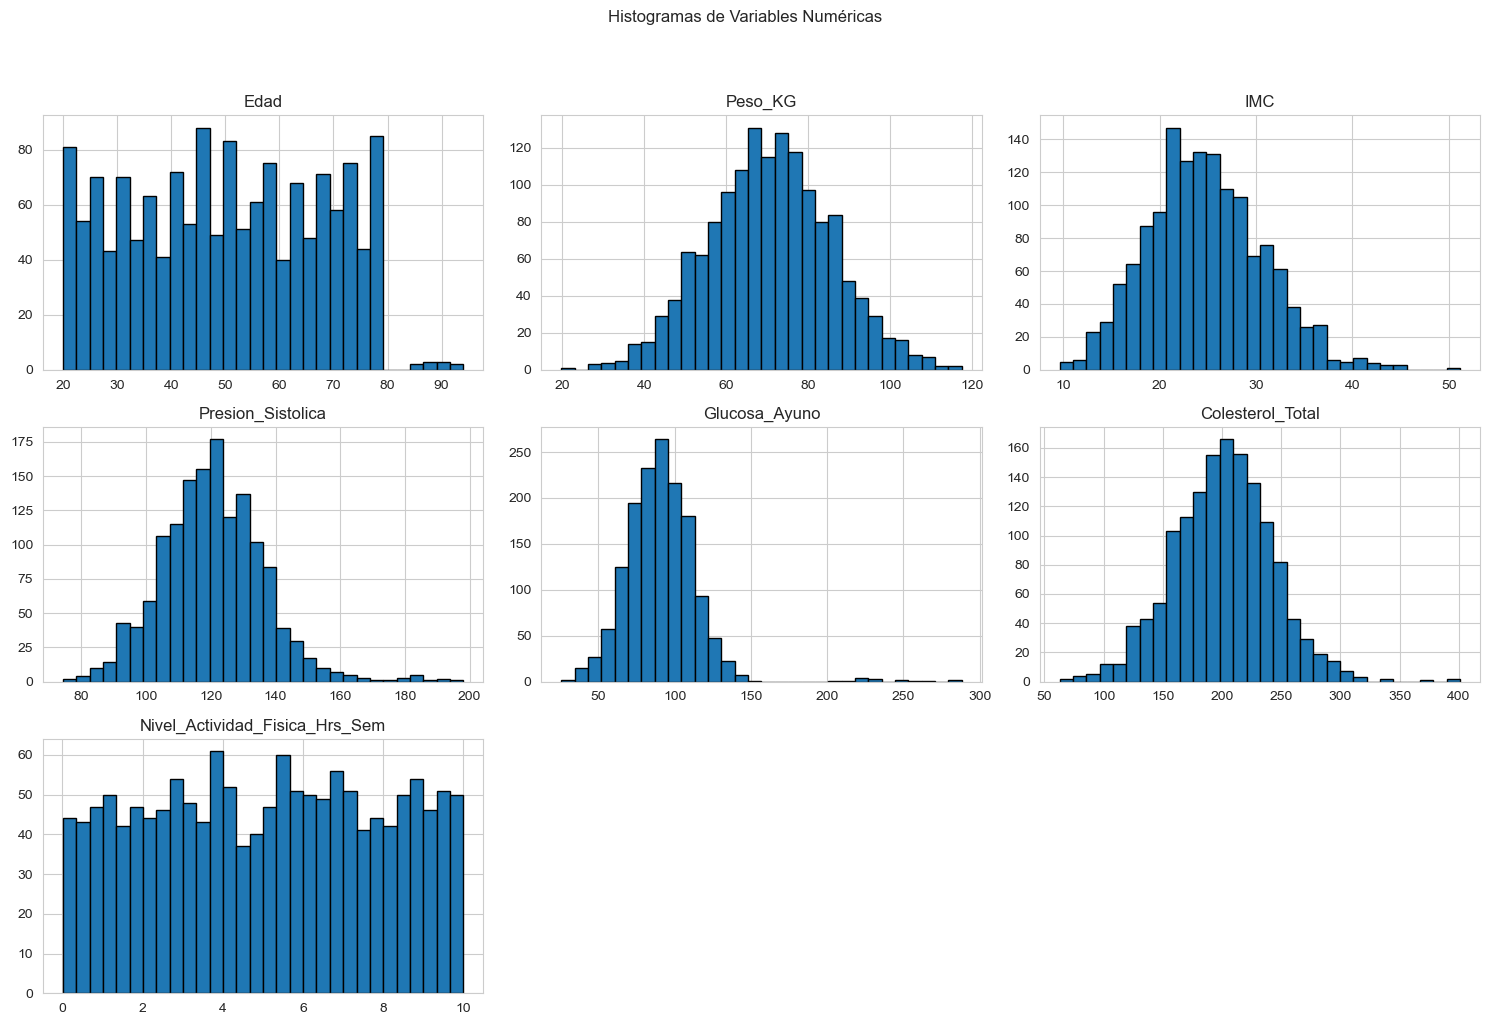


--- 2.4.2 Diagramas de Caja (Box Plots) para Identificar Outliers ---


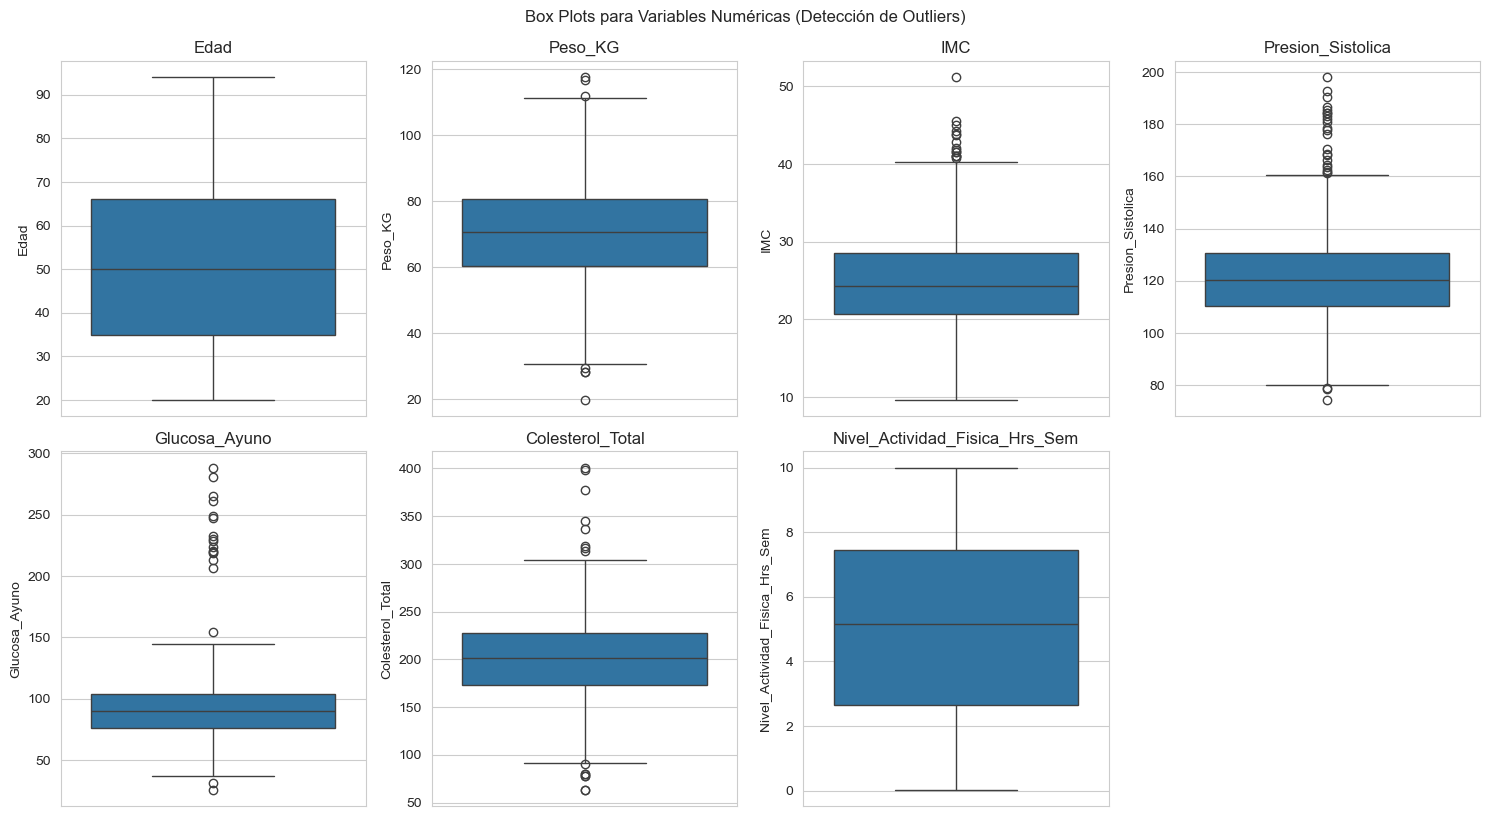


--- 2.4.3 Distribución de Variables Categóricas (Count Plots) ---


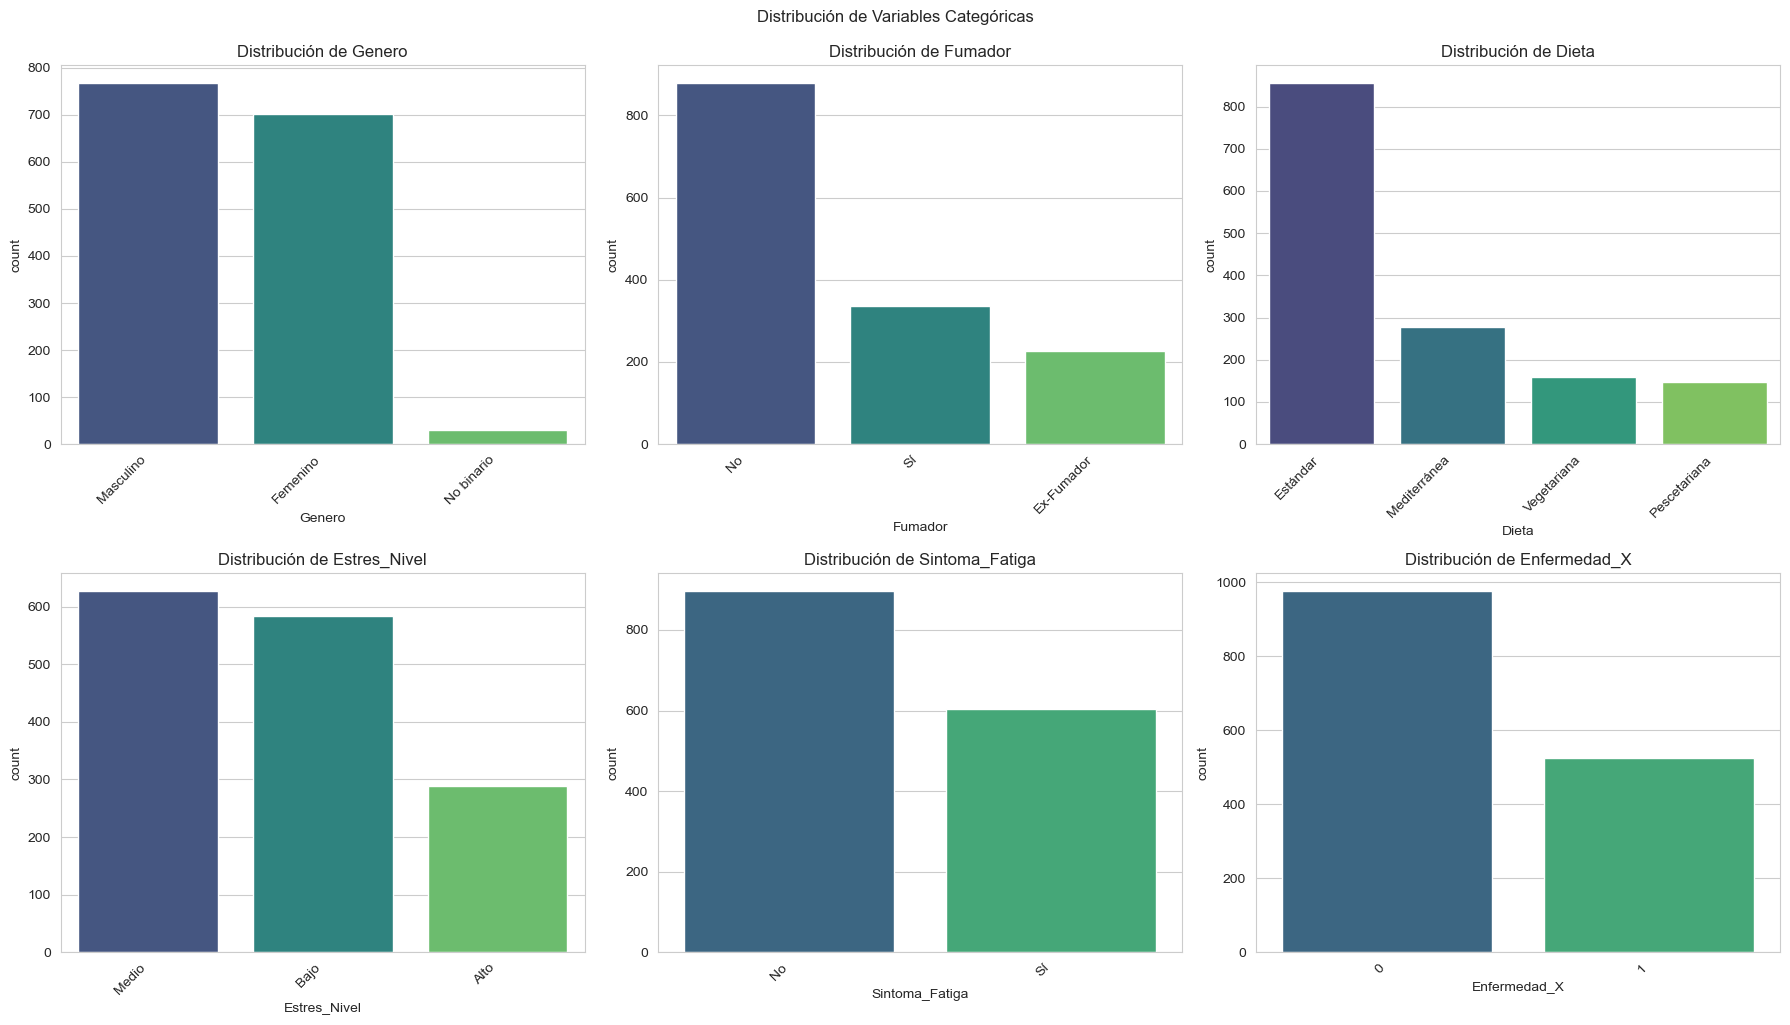


--- 2.4.4 Correlación entre Variables Numéricas ---


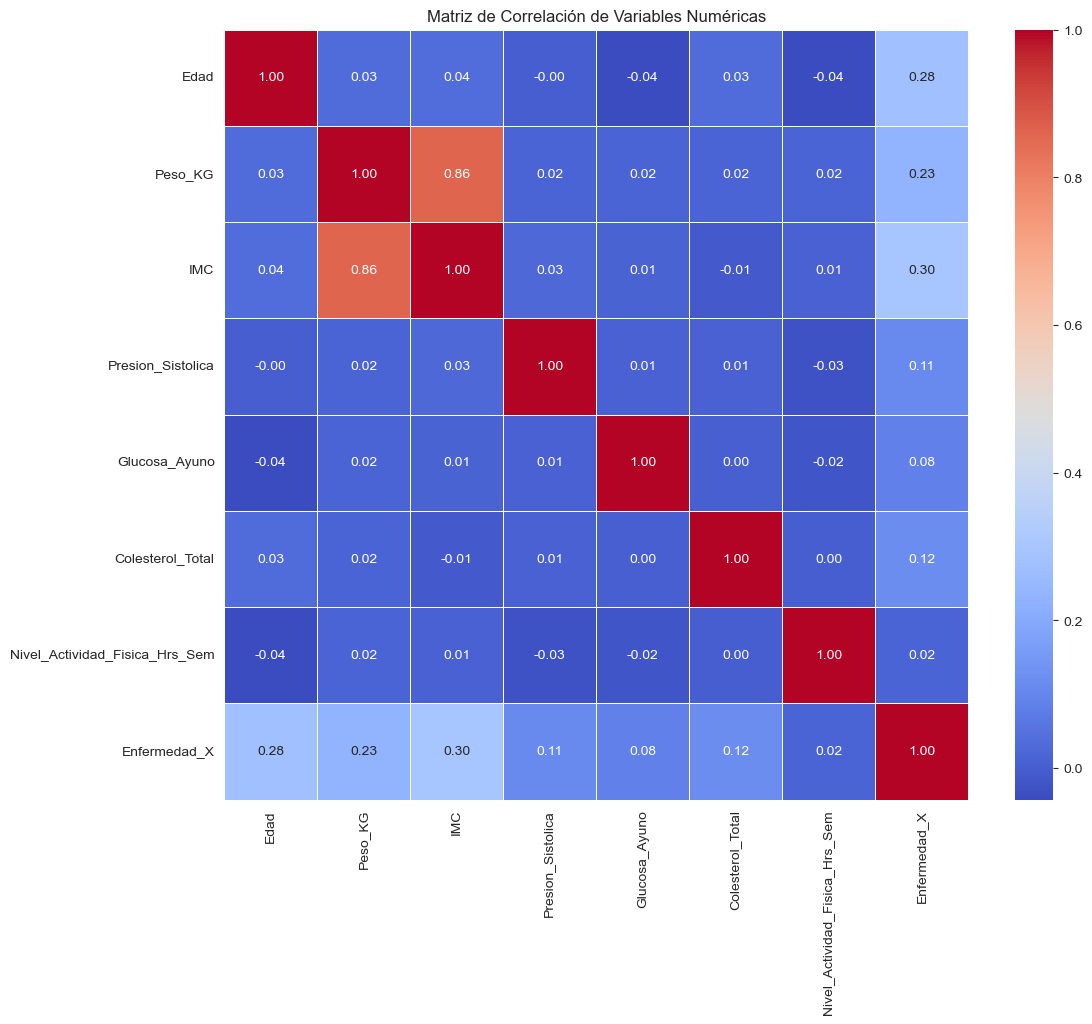


--- 2.4.5 Relación de Variables Clave con la Enfermedad_X ---


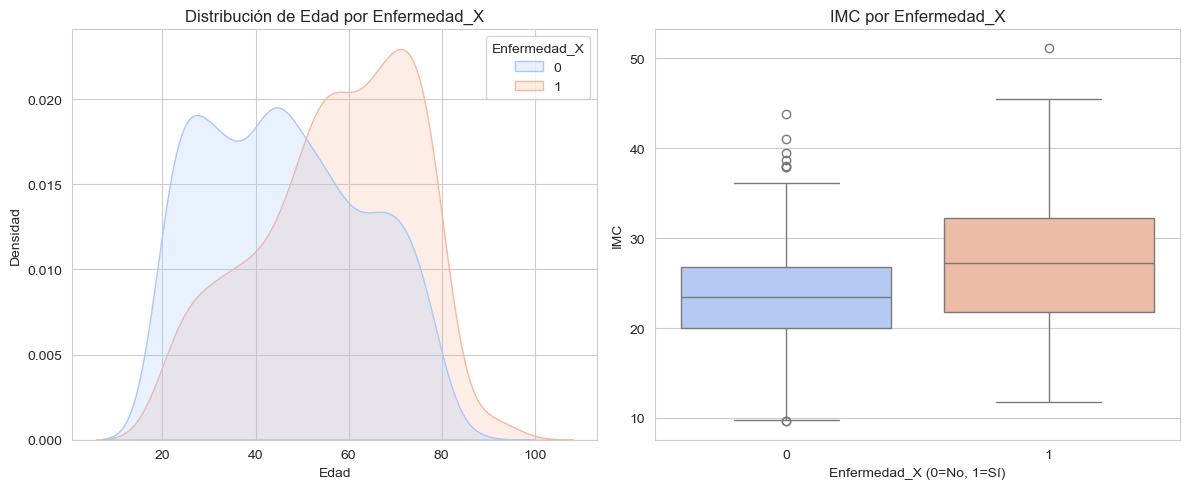

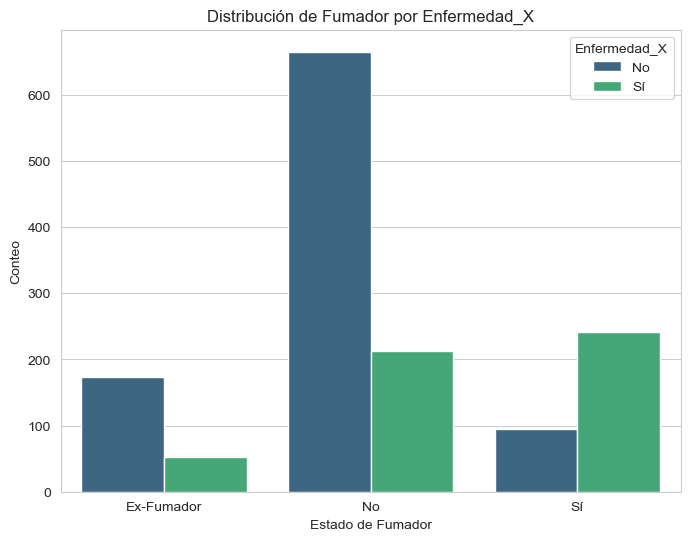


EDA completado. Hemos comprendido la estructura y las distribuciones de los datos.


In [34]:
# %% [markdown]
# ### 2. Exploración Inicial del Dataset (EDA)
#
# Una vez generado nuestro dataset, es fundamental realizar un Análisis Exploratorio de Datos (EDA) para entender su estructura, la distribución de sus variables, identificar patrones, anomalías y la presencia de valores nulos.
#

# %%
print("\n--- 2.1 Información General del Dataset ---")
print(data.info())

print("\n--- 2.2 Estadísticas Descriptivas de Variables Numéricas ---")
print(data.describe())

print("\n--- 2.3 Conteo de Valores para Variables Categóricas ---")
for col in ['Genero', 'Fumador', 'Dieta', 'Estres_Nivel', 'Grupo_Sanguineo', 'Sintoma_Dolor_Cabeza', 'Sintoma_Fatiga', 'Sintoma_Nauseas', 'Enfermedad_X']:
    if col in data.columns:
        print(f"\nDistribución de '{col}':")
        print(data[col].value_counts(dropna=False)) # dropna=False para ver nulos si los hay


# %% [markdown]
# ### 2.4 Visualizaciones Clave
#
# Las visualizaciones nos ayudan a entender las distribuciones y las relaciones de manera gráfica.

# %%
print("\n--- 2.4.1 Histograma de Variables Numéricas Clave ---")
numeric_cols_for_hist = ['Edad', 'Peso_KG', 'IMC', 'Presion_Sistolica', 'Glucosa_Ayuno', 'Colesterol_Total', 'Nivel_Actividad_Fisica_Hrs_Sem']
data[numeric_cols_for_hist].hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle('Histogramas de Variables Numéricas', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Ajustar para el título superior
plt.show()

print("\n--- 2.4.2 Diagramas de Caja (Box Plots) para Identificar Outliers ---")
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols_for_hist):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(y=data[col])
    plt.title(col)
plt.tight_layout()
plt.suptitle('Box Plots para Variables Numéricas (Detección de Outliers)', y=1.02)
plt.show()


print("\n--- 2.4.3 Distribución de Variables Categóricas (Count Plots) ---")
categorical_cols_for_plot = ['Genero', 'Fumador', 'Dieta', 'Estres_Nivel', 'Sintoma_Fatiga', 'Enfermedad_X']
plt.figure(figsize=(18, 10))
for i, col in enumerate(categorical_cols_for_plot):
    plt.subplot(2, 3, i + 1)
    sns.countplot(data=data, x=col, palette='viridis', order=data[col].value_counts().index)
    plt.title(f'Distribución de {col}')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.suptitle('Distribución de Variables Categóricas', y=1.02)
plt.show()

print("\n--- 2.4.4 Correlación entre Variables Numéricas ---")
# Calculamos la matriz de correlación
numeric_data = data[numeric_cols_for_hist + ['Enfermedad_X']].copy()
# Reemplazar NaN en la matriz de correlación con la media para una visualización (no para el modelo)
# O simplemente usar dropna para la correlación si no queremos imputar solo para la visualización
correlation_matrix = numeric_data.dropna().corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

print("\n--- 2.4.5 Relación de Variables Clave con la Enfermedad_X ---")
# Densidad de Edad por Enfermedad
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(data=data, x='Edad', hue='Enfermedad_X', fill=True, common_norm=False, palette='coolwarm')
plt.title('Distribución de Edad por Enfermedad_X')
plt.xlabel('Edad')
plt.ylabel('Densidad')

# Boxplot de IMC por Enfermedad
plt.subplot(1, 2, 2)
sns.boxplot(data=data, x='Enfermedad_X', y='IMC', palette='coolwarm')
plt.title('IMC por Enfermedad_X')
plt.xlabel('Enfermedad_X (0=No, 1=Sí)')
plt.ylabel('IMC')
plt.tight_layout()
plt.show()


# Countplot de Fumador por Enfermedad
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Fumador', hue='Enfermedad_X', palette='viridis')
plt.title('Distribución de Fumador por Enfermedad_X')
plt.xlabel('Estado de Fumador')
plt.ylabel('Conteo')
plt.legend(title='Enfermedad_X', labels=['No', 'Sí'])
plt.show()

print("\nEDA completado. Hemos comprendido la estructura y las distribuciones de los datos.")

In [2]:
# %% [markdown]
# ### 3. Pipeline de Preprocesamiento de Datos
#
# El preprocesamiento es una fase crítica en el flujo de trabajo de Machine Learning. Aquí construiremos un pipeline robusto usando `ColumnTransformer` y `Pipeline` de Scikit-learn para manejar valores nulos, codificar variables categóricas y escalar variables numéricas.
#
# Las técnicas de Feature Engineering que abordaremos en este paso son:
# * **Data Imputation** (Imputación de Datos)
# * **Categorical Encoding** (Codificación Categórica)
# * **Feature Scaling** (Escalado de Características)
# * **Datetime Data Handling** (Manejo de Datos de Fecha/Hora, extrayendo nuevas características numéricas de la fecha)
#

# %%
print("\n--- 3.1 Separación de Datos: Entrenamiento y Prueba ---")
# La variable 'ID_Paciente' no es una característica predictiva, así que la excluimos.
X = data.drop(columns=['ID_Paciente', 'Enfermedad_X'])
y = data['Enfermedad_X']

# Dividir el dataset en conjuntos de entrenamiento y prueba
# Usamos stratify=y para asegurar que la proporción de Enfermedad_X sea la misma en ambos conjuntos.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Distribución de la clase en y_train:\n{y_train.value_counts(normalize=True)}")
print(f"Distribución de la clase en y_test:\n{y_test.value_counts(normalize=True)}")


# %% [markdown]
# ### 3.2 Ingeniería de Características de Fecha (Antes del Pipeline Principal)
#
# Primero, transformaremos la columna `Fecha_Ultima_Revision` en características numéricas útiles. Esto se hace antes del `ColumnTransformer` porque involucra cálculos sobre la columna de fecha que luego se tratará como numérica.

# %%
print("\n--- 3.2 Ingeniería de Características de Fecha/Hora ---")

# Calculamos los días desde la última revisión hasta una fecha de referencia (ej. hoy)
# Usaremos la fecha_actual definida en la generación del dataset
current_date_ref = pd.to_datetime('2025-01-01')

# Aplicar a los conjuntos de entrenamiento y prueba
X_train['Dias_Desde_Ultima_Revision'] = (current_date_ref - X_train['Fecha_Ultima_Revision']).dt.days
X_test['Dias_Desde_Ultima_Revision'] = (current_date_ref - X_test['Fecha_Ultima_Revision']).dt.days

# También podríamos extraer mes y año si fueran relevantes cíclicamente
X_train['Mes_Ultima_Revision'] = X_train['Fecha_Ultima_Revision'].dt.month
X_test['Mes_Ultima_Revision'] = X_test['Fecha_Ultima_Revision'].dt.month

X_train['Año_Ultima_Revision'] = X_train['Fecha_Ultima_Revision'].dt.year
X_test['Año_Ultima_Revision'] = X_test['Fecha_Ultima_Revision'].dt.year

# Una vez extraídas, podemos eliminar la columna original de fecha
X_train = X_train.drop(columns=['Fecha_Ultima_Revision'])
X_test = X_test.drop(columns=['Fecha_Ultima_Revision'])

print("Características de fecha extraídas y columna original eliminada.")
print(f"Columnas de X_train después de FE de fecha: {X_train.columns.tolist()}")


# %% [markdown]
# ### 3.3 Definición del Pipeline de Preprocesamiento (`ColumnTransformer`)
#
# Ahora, construiremos el `ColumnTransformer` que aplicará diferentes transformaciones a diferentes tipos de columnas.

# %%
print("\n--- 3.3 Definición del Pipeline de Preprocesamiento ---")

# Identificar tipos de columnas después de la ingeniería de características de fecha
# Asegúrate de que las columnas originales que eran datetime ahora son numéricas (Dias_Desde_Ultima_Revision, etc.)
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()

print(f"Características numéricas identificadas: {numeric_features}")
print(f"Características categóricas identificadas: {categorical_features}")

# Pipeline para características numéricas: imputación con la mediana y escalado estándar
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para características categóricas: imputación con la moda y OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # handle_unknown='ignore' para evitar errores con categorías no vistas en test
])

# Combinar preprocesadores usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Descarta cualquier columna no especificada (como ID_Paciente, que ya quitamos)
)

print("Preprocesador (ColumnTransformer) configurado.")
print("\nEl pipeline de preprocesamiento está listo para ser integrado en los modelos.")


--- 3.1 Separación de Datos: Entrenamiento y Prueba ---
Dimensiones de X_train: (1200, 21)
Dimensiones de X_test: (300, 21)
Distribución de la clase en y_train:
Enfermedad_X
0    0.65
1    0.35
Name: proportion, dtype: float64
Distribución de la clase en y_test:
Enfermedad_X
0    0.65
1    0.35
Name: proportion, dtype: float64

--- 3.2 Ingeniería de Características de Fecha/Hora ---
Características de fecha extraídas y columna original eliminada.
Columnas de X_train después de FE de fecha: ['Edad', 'Peso_KG', 'Altura_CM', 'Presion_Sistolica', 'Presion_Diastolica', 'Colesterol_Total', 'Glucosa_Ayuno', 'Nivel_Actividad_Fisica_Hrs_Sem', 'Consumo_Alcohol_Unidades_Sem', 'Num_Visitas_Medico_Ult_Año', 'Historial_Familiar_Enfermedad_X_Score', 'Genero', 'Fumador', 'Dieta', 'Estres_Nivel', 'Grupo_Sanguineo', 'Sintoma_Dolor_Cabeza', 'Sintoma_Fatiga', 'Sintoma_Nauseas', 'IMC', 'Dias_Desde_Ultima_Revision', 'Mes_Ultima_Revision', 'Año_Ultima_Revision']

--- 3.3 Definición del Pipeline de Preproces


--- 4.1 Definición y Entrenamiento de Pipelines de Clasificación ---

Entrenando y evaluando: Decision Tree...
--- Resultados para Decision Tree ---
Accuracy: 0.7833
Precision: 0.6887
Recall: 0.6952
F1-Score: 0.6919
ROC AUC: 0.7630
Matriz de Confusión:
[[162  33]
 [ 32  73]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       195
           1       0.69      0.70      0.69       105

    accuracy                           0.78       300
   macro avg       0.76      0.76      0.76       300
weighted avg       0.78      0.78      0.78       300


Entrenando y evaluando: Support Vector Machine (SVM)...
--- Resultados para Support Vector Machine (SVM) ---
Accuracy: 0.8067
Precision: 0.7474
Recall: 0.6762
F1-Score: 0.7100
ROC AUC: 0.8966
Matriz de Confusión:
[[171  24]
 [ 34  71]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       19

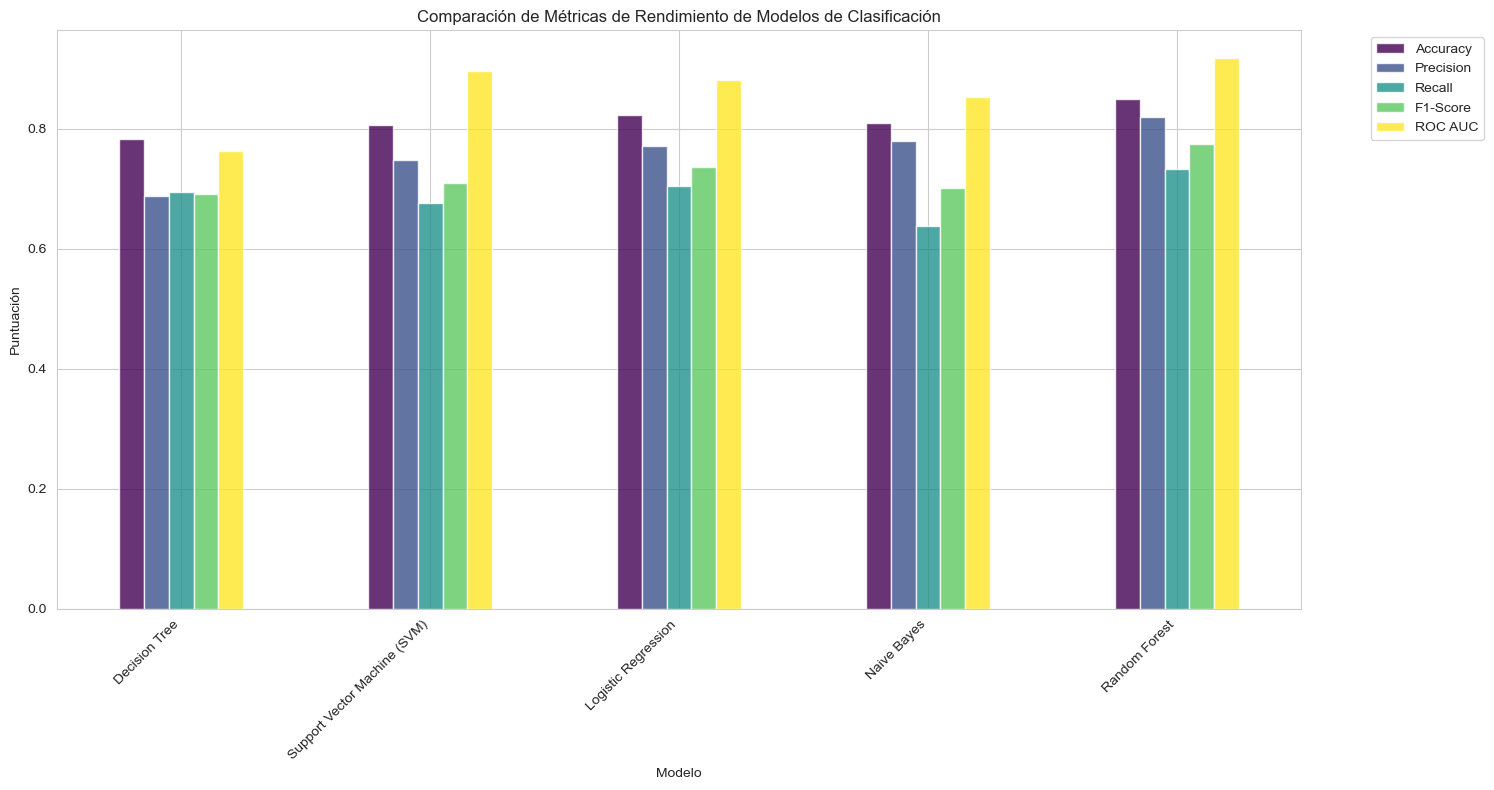


--- 4.3 Visualización de Matrices de Confusión y Curvas ROC ---


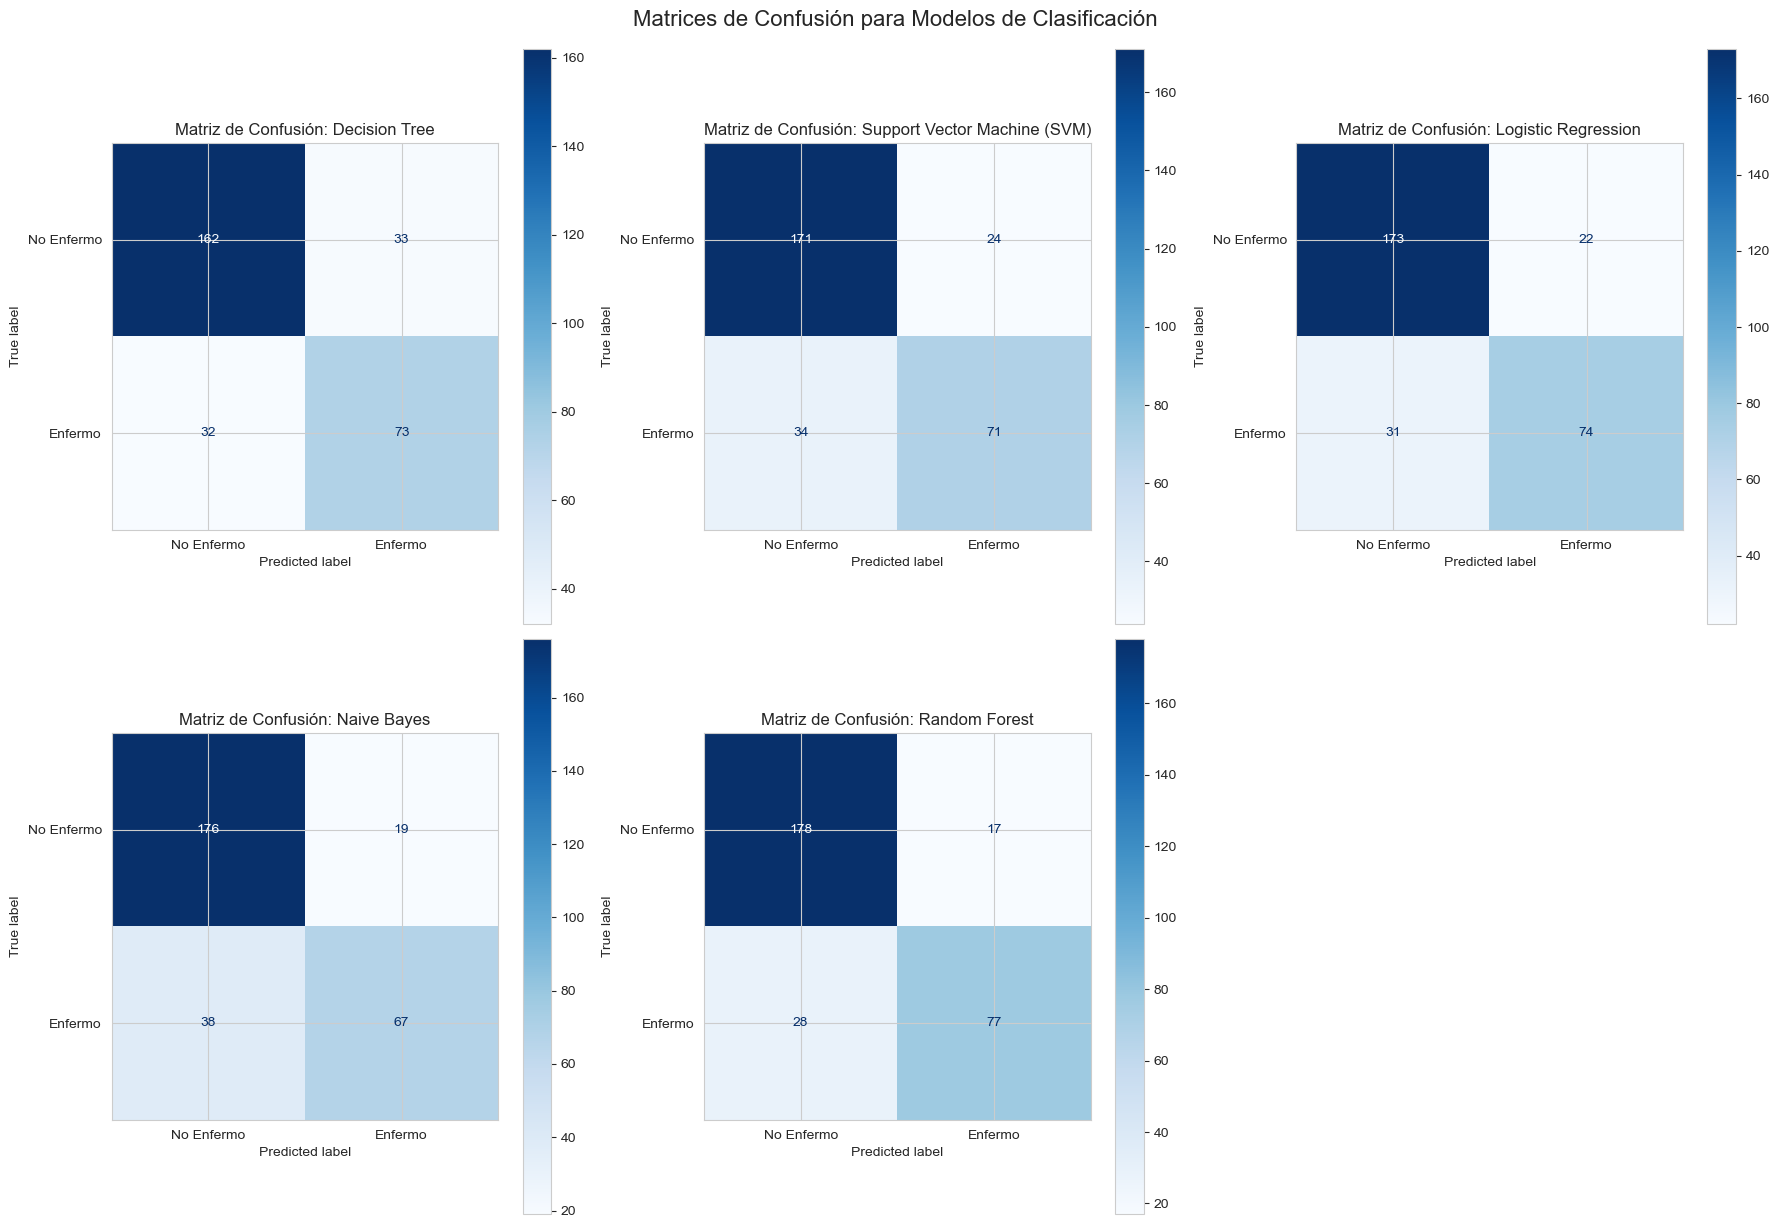

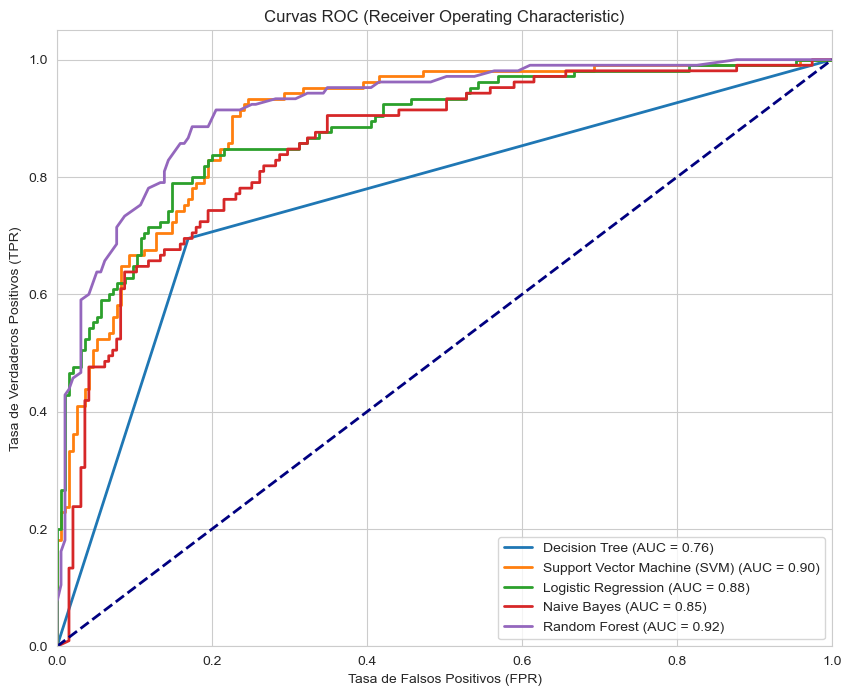


Comparación de modelos completada. Los resultados muestran que algunos modelos rinden mejor que otros para este dataset sintético.


In [36]:
# %% [markdown]
# ### 4. Pipeline Completo para Clasificación con Modelos Comparativos
#
# Con nuestro `preprocessor` listo, construiremos pipelines completos integrándolo con varios modelos de clasificación. Esto nos permitirá entrenar, evaluar y comparar el rendimiento de diferentes algoritmos de forma estructurada.
#
# Evaluaremos los siguientes modelos:
# * **Árbol de Decisión**
# * **Máquina de Vectores de Soporte (SVM)**
# * **Regresión Logística**
# * **Naive Bayes**
# * **Random Forest**
#

# %%
print("\n--- 4.1 Definición y Entrenamiento de Pipelines de Clasificación ---")

# Diccionario para almacenar los modelos y sus pipelines
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Support Vector Machine (SVM)': SVC(probability=True, random_state=42), # probability=True para calcular ROC AUC
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'), # solver='liblinear' bueno para datasets pequeños y binarios
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Diccionario para almacenar los resultados de la evaluación
results = {}

# Iterar sobre cada modelo, construir el pipeline, entrenar y evaluar
for name, model in models.items():
    print(f"\nEntrenando y evaluando: {name}...")

    # Crear el pipeline completo: preprocesador + modelo
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', model)])

    # Entrenar el pipeline con los datos de entrenamiento
    full_pipeline.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = full_pipeline.predict(X_test)
    y_prob = full_pipeline.predict_proba(X_test)[:, 1] # Probabilidades para ROC AUC

    # Evaluar el modelo
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc,
        'Confusion Matrix': conf_matrix,
        'Pipeline': full_pipeline # Guardamos el pipeline entrenado
    }

    print(f"--- Resultados para {name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Matriz de Confusión:\n{conf_matrix}")
    print(f"Reporte de Clasificación:\n{classification_report(y_test, y_pred)}")


# %% [markdown]
# ### 4.2 Comparación de Resultados y Visualizaciones
#
# Visualicemos las métricas para una comparación más sencilla.

# %%
print("\n--- 4.2 Comparación Visual de Métricas de Modelos ---")

# Convertir los resultados a un DataFrame para fácil visualización
results_df = pd.DataFrame.from_dict(results, orient='index')
# Excluimos la matriz de confusión y el pipeline para la visualización de barras
metrics_df = results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']]

print("\nResumen de Métricas de Rendimiento por Modelo:")
print(metrics_df)

# Graficar métricas para comparar
metrics_df.plot(kind='bar', figsize=(15, 8), colormap='viridis', alpha=0.8)
plt.title('Comparación de Métricas de Rendimiento de Modelos de Clasificación')
plt.ylabel('Puntuación')
plt.xlabel('Modelo')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# %% [markdown]
# ### 4.3 Visualización de Matrices de Confusión y Curvas ROC
#
# Para una comprensión más profunda del rendimiento de cada clasificador, visualizaremos sus **Matrices de Confusión** y **Curvas ROC (Receiver Operating Characteristic)**.
#
# * La **Matriz de Confusión** nos ayuda a entender los tipos de errores (falsos positivos, falsos negativos) que comete un modelo.
# * La **Curva ROC** y el **Área Bajo la Curva (AUC)** evalúan la capacidad del modelo para distinguir entre clases, especialmente útil para clases desbalanceadas. Un AUC más cercano a 1.0 indica un mejor rendimiento.

# %%
print("\n--- 4.3 Visualización de Matrices de Confusión y Curvas ROC ---")

# Graficar Matrices de Confusión
fig, axes = plt.subplots(2, 3, figsize=(18, 12)) # 2 filas, 3 columnas para 5 modelos
axes = axes.flatten() # Aplanar el array de axes para fácil iteración

for i, (name, res) in enumerate(results.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=res['Confusion Matrix'], display_labels=['No Enfermo', 'Enfermo'])
    disp.plot(cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Matriz de Confusión: {name}')

# Ocultar cualquier subplot vacío si el número de modelos no llena la cuadrícula
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Matrices de Confusión para Modelos de Clasificación', y=1.02, fontsize=16)
plt.show()


# Graficar Curvas ROC
plt.figure(figsize=(10, 8))
lw = 2 # Ancho de línea

for name, res in results.items():
    # Para dibujar la curva ROC, necesitamos las probabilidades de predicción.
    # Tenemos que re-predecir las probabilidades porque solo almacenamos el pipeline entrenado
    # y RocCurveDisplay necesita el modelo (o el pipeline con predict_proba) y los datos de prueba.
    # Opcional: si ya las calculamos arriba, podríamos pasarlas directamente
    # Pero para consistencia y si se ejecuta esta celda de forma independiente, es mejor usar el pipeline guardado.
    full_pipeline = res['Pipeline']
    y_prob = full_pipeline.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = res['ROC AUC'] # Usamos el AUC ya calculado

    plt.plot(fpr, tpr, lw=lw, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\nComparación de modelos completada. Los resultados muestran que algunos modelos rinden mejor que otros para este dataset sintético.")


--- 5.1 Revisión de Outliers (recordatorio) ---


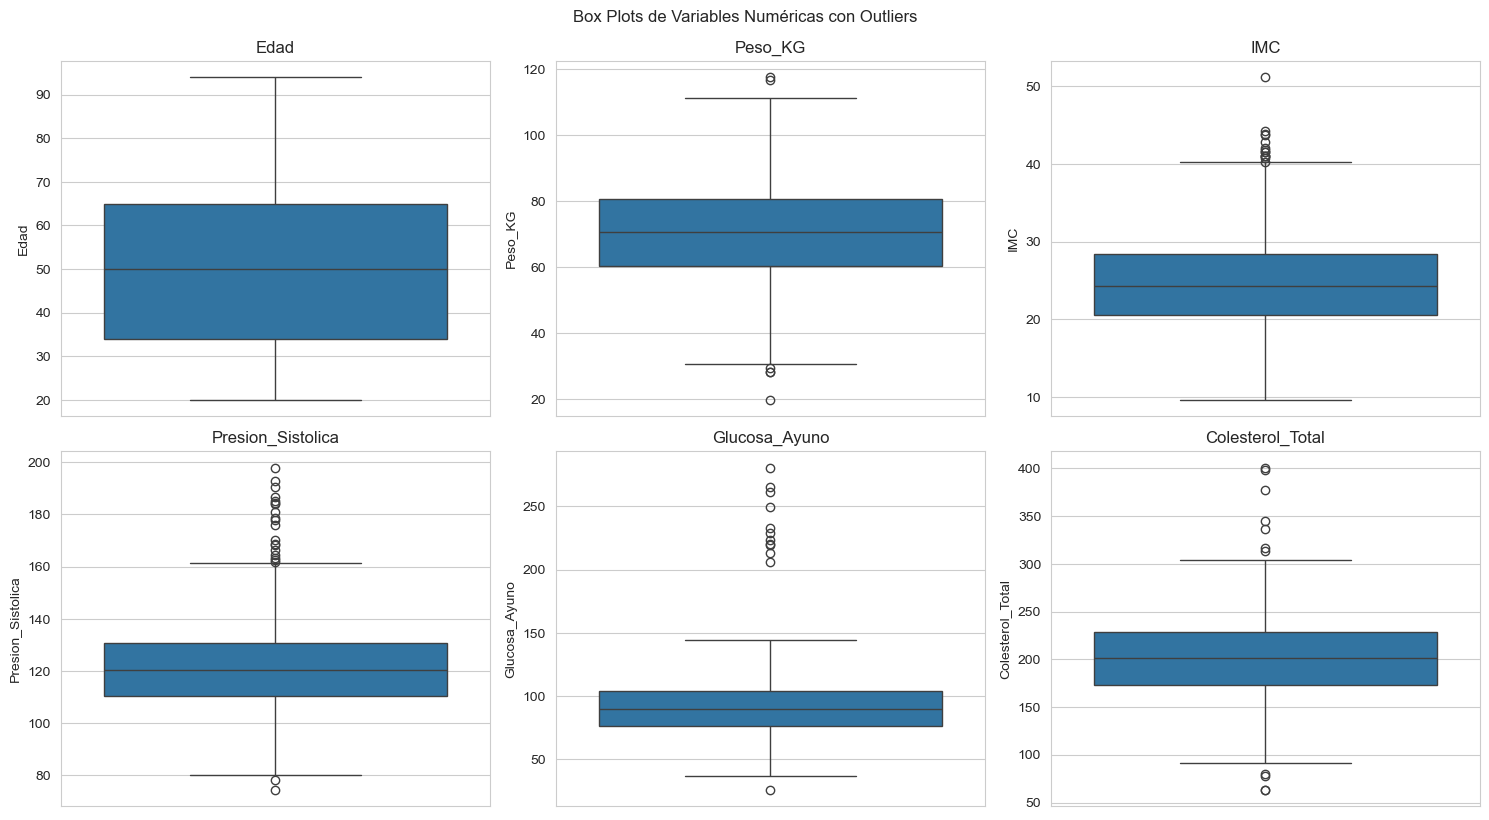


--- 5.2.1 Custom Transformer: OutlierCapper ---

--- 5.2.2 Custom Transformer: YeoJohnsonTransformer ---

--- 5.2.3 Custom Transformer: CustomDiscretizer (KBinsDiscretizer wrapper) ---
Custom Transformers (OutlierCapper, YeoJohnsonTransformer, CustomDiscretizer) definidos.

--- 5.3 Actualización del Pipeline de Preprocesamiento ---
Numéricas para capping de outliers: ['Presion_Sistolica', 'Colesterol_Total', 'Glucosa_Ayuno', 'IMC']
Numéricas para Yeo-Johnson: ['Nivel_Actividad_Fisica_Hrs_Sem', 'Consumo_Alcohol_Unidades_Sem']
Numéricas para discretización: ['Edad', 'Historial_Familiar_Enfermedad_X_Score']
Numéricas restantes (solo imputación y escalado): ['Presion_Diastolica', 'Dias_Desde_Ultima_Revision', 'Num_Visitas_Medico_Ult_Año', 'Altura_CM', 'Mes_Ultima_Revision', 'Peso_KG', 'Año_Ultima_Revision']
Preprocesador avanzado (ColumnTransformer) configurado con manejo de outliers, transformación de variables y discretización.

Ahora podemos usar 'preprocessor_advanced' en nuestros pip

In [37]:
# %% [markdown]
# ### 5. Profundizar en Técnicas Específicas de Feature Engineering
#
# En este paso, nos enfocaremos en técnicas más avanzadas de Feature Engineering para mejorar la calidad de nuestras características numéricas, y demostraremos cómo crear **Operadores a la Medida (Custom Transformers)** utilizando `BaseEstimator` y `TransformerMixin`.
#
# Las técnicas a cubrir son:
# * **Outlier Handling (Manejo de Outliers):** Recorte (capping) de valores atípicos.
# * **Variable Transformation (Transformación de Variables):** Aplicación de transformaciones (ej., Yeo-Johnson) para normalizar distribuciones.
# * **Discretization (Discretización):** Conversión de variables continuas en bins categóricos.
#
# Para una integración fluida en nuestro pipeline, encapsularemos estas lógicas en transformadores personalizados de Scikit-learn.
#

# %%
print("\n--- 5.1 Revisión de Outliers (recordatorio) ---")
# Volvemos a mostrar algunos box plots para recordar la presencia de outliers.
numeric_cols_for_hist = ['Edad', 'Peso_KG', 'IMC', 'Presion_Sistolica', 'Glucosa_Ayuno', 'Colesterol_Total']
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols_for_hist):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=X_train[col].dropna()) # Dropna para visualizar sin nulos
    plt.title(col)
plt.tight_layout()
plt.suptitle('Box Plots de Variables Numéricas con Outliers', y=1.02)
plt.show()


# %% [markdown]
# ### 5.2 Creación de Operadores a la Medida (Custom Transformers)
#
# Implementaremos `OutlierCapper`, `YeoJohnsonTransformer` y `CustomDiscretizer`.
# Estas clases se basan en `BaseEstimator` y `TransformerMixin` para que sean compatibles con los pipelines de Scikit-learn.

# %%
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer, KBinsDiscretizer

print("\n--- 5.2.1 Custom Transformer: OutlierCapper ---")
class OutlierCapper(BaseEstimator, TransformerMixin):
    """
    Un transformador personalizado para limitar los outliers en columnas numéricas
    utilizando el método IQR (Rango Intercuartílico).
    Los valores por encima de Q3 + 1.5*IQR se limitan a Q3 + 1.5*IQR.
    Los valores por debajo de Q1 - 1.5*IQR se limitan a Q1 - 1.5*IQR.
    """
    def __init__(self, factor=1.5):
        self.factor = factor
        self.upper_bounds_ = {}
        self.lower_bounds_ = {}

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X) # Asegurarse de que X es un DataFrame para cálculos de cuartiles
        for col in X.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            self.upper_bounds_[col] = Q3 + (self.factor * IQR)
            self.lower_bounds_[col] = Q1 - (self.factor * IQR)
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.upper_bounds_.keys()) # Necesitamos los nombres de las columnas
        X_transformed = X.copy()
        for col in X_transformed.columns:
            if col in self.upper_bounds_ and col in self.lower_bounds_: # Asegurarse de que el fit fue para esta columna
                upper = self.upper_bounds_[col]
                lower = self.lower_bounds_[col]
                X_transformed[col] = np.where(X_transformed[col] > upper, upper, X_transformed[col])
                X_transformed[col] = np.where(X_transformed[col] < lower, lower, X_transformed[col])
        return X_transformed


print("\n--- 5.2.2 Custom Transformer: YeoJohnsonTransformer ---")
class YeoJohnsonTransformer(BaseEstimator, TransformerMixin):
    """
    Un transformador personalizado para aplicar la transformación Yeo-Johnson
    a columnas numéricas. Maneja valores negativos y cero.
    """
    def __init__(self):
        self.transformer_ = None

    def fit(self, X, y=None):
        # PowerTransformer aplica Yeo-Johnson por defecto
        # copy=False para transformar in-place si es posible, aunque aquí siempre haremos copia para seguridad
        self.transformer_ = PowerTransformer(method='yeo-johnson', standardize=False) # No estandarizamos aquí, solo transformamos
        self.transformer_.fit(X)
        return self

    def transform(self, X):
        if self.transformer_ is None:
            raise RuntimeError("Transformer has not been fitted yet. Call fit() first.")
        return self.transformer_.transform(X)


print("\n--- 5.2.3 Custom Transformer: CustomDiscretizer (KBinsDiscretizer wrapper) ---")
class CustomDiscretizer(BaseEstimator, TransformerMixin):
    """
    Un transformador personalizado para discretizar variables numéricas en bins.
    Envuelve KBinsDiscretizer para integrarlo en nuestro pipeline.
    """
    def __init__(self, n_bins=5, strategy='quantile'):
        self.n_bins = n_bins
        self.strategy = strategy # 'uniform', 'quantile', 'kmeans'
        self.discretizer_ = None

    def fit(self, X, y=None):
        # KBinsDiscretizer espera un array 2D
        self.discretizer_ = KBinsDiscretizer(n_bins=self.n_bins, encode='ordinal', strategy=self.strategy, subsample=200_000, random_state=42)
        self.discretizer_.fit(X)
        return self

    def transform(self, X):
        if self.discretizer_ is None:
            raise RuntimeError("Discretizer has not been fitted yet. Call fit() first.")
        # KBinsDiscretizer devuelve un array, necesitamos asegurarnos de que sea un DataFrame si hay múltiples columnas
        # y preservar los nombres de las columnas para el ColumnTransformer.
        # En el contexto del ColumnTransformer, transformará una sola columna o un grupo.
        # Aquí, transformaría las columnas que le sean pasadas.
        return self.discretizer_.transform(X)

print("Custom Transformers (OutlierCapper, YeoJohnsonTransformer, CustomDiscretizer) definidos.")

# %% [markdown]
# ### 5.3 Actualización del `ColumnTransformer` con Nuevas Técnicas de Feature Engineering
#
# Ahora, modificaremos nuestro `preprocessor` para incluir los nuevos transformadores personalizados.
#
# Consideraremos aplicar estas técnicas a un subconjunto de variables numéricas donde sean más relevantes.
#
# * **Manejo de Outliers:** Aplicaremos `OutlierCapper` a `Presion_Sistolica`, `Colesterol_Total`, `Glucosa_Ayuno`, `IMC`.
# * **Transformación de Variables:** Aplicaremos `YeoJohnsonTransformer` a `Nivel_Actividad_Fisica_Hrs_Sem` y `Consumo_Alcohol_Unidades_Sem`, que a menudo tienen distribuciones sesgadas.
# * **Discretización:** Aplicaremos `CustomDiscretizer` a `Edad` (para crear grupos de edad) y `Historial_Familiar_Enfermedad_X_Score`.

# %%
print("\n--- 5.3 Actualización del Pipeline de Preprocesamiento ---")

# Re-identificar tipos de columnas (las columnas de fecha ya fueron manejadas)
numeric_features_original = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()

# Definir subconjuntos de características numéricas para transformaciones específicas
outlier_cap_features = ['Presion_Sistolica', 'Colesterol_Total', 'Glucosa_Ayuno', 'IMC']
yeo_johnson_features = ['Nivel_Actividad_Fisica_Hrs_Sem', 'Consumo_Alcohol_Unidades_Sem']
discretize_features = ['Edad', 'Historial_Familiar_Enfermedad_X_Score']

# Las características restantes numéricas se imputarán y escalarán normalmente
# Se usa un set para facilidad en la resta de conjuntos
remaining_numeric_features = list(set(numeric_features_original) - set(outlier_cap_features) - set(yeo_johnson_features) - set(discretize_features))

print(f"Numéricas para capping de outliers: {outlier_cap_features}")
print(f"Numéricas para Yeo-Johnson: {yeo_johnson_features}")
print(f"Numéricas para discretización: {discretize_features}")
print(f"Numéricas restantes (solo imputación y escalado): {remaining_numeric_features}")


# Nuevo preprocessor con los transformadores personalizados
preprocessor_advanced = ColumnTransformer(
    transformers=[
        # 1. Pipeline para manejo de nulos y escalado estándar (para la mayoría de numéricas)
        ('num_standard', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), remaining_numeric_features),

        # 2. Pipeline para capping de outliers, imputación y escalado
        ('num_outlier_capped', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('capper', OutlierCapper(factor=1.5)), # Ajustar factor si es necesario
            ('scaler', StandardScaler())
        ]), outlier_cap_features),

        # 3. Pipeline para transformación Yeo-Johnson, imputación y escalado
        ('num_yeo_johnson', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('yj_transform', YeoJohnsonTransformer()),
            ('scaler', StandardScaler()) # Escalar después de la transformación
        ]), yeo_johnson_features),

        # 4. Pipeline para discretización, imputación (si es necesario) y OneHotEncoding de los bins
        # NOTA: KBinsDiscretizer puede manejar NaN con 'passthrough', o podemos imputar antes
        # Aquí imputamos antes por consistencia con otros numéricos
        ('num_discretized', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')), # Imputar antes de discretizar
            ('discretizer', CustomDiscretizer(n_bins=5, strategy='quantile')),
            ('onehot', OneHotEncoder(handle_unknown='ignore')) # Discretizer output es ordinal, OneHot para bins
        ]), discretize_features),

        # 5. Pipeline para categóricas: imputación y OneHotEncoding (sin cambios)
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ],
    remainder='drop'
)

print("Preprocesador avanzado (ColumnTransformer) configurado con manejo de outliers, transformación de variables y discretización.")
print("\nAhora podemos usar 'preprocessor_advanced' en nuestros pipelines de modelos.")

# Opcional: Probar el preprocesador avanzado en X_train para ver los resultados
# Esto puede ser muy útil para depuración, pero genera un array numpy grande.
# X_train_transformed_advanced = preprocessor_advanced.fit_transform(X_train)
# print(f"\nDimensiones de X_train transformado con preprocesador avanzado: {X_train_transformed_advanced.shape}")
# print("Las primeras 5 filas del dataset transformado (solo para inspección, es un array numpy):")
# print(X_train_transformed_advanced[:5, :])


--- 6.1 Optimización de Hiperparámetros para Árbol de Decisión (GridSearchCV) ---
Iniciando GridSearchCV para Árbol de Decisión...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Mejores hiperparámetros para Árbol de Decisión: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}
Mejor ROC AUC en validación cruzada para Árbol de Decisión: 0.8263
ROC AUC en el conjunto de prueba (Árbol de Decisión Optimizado): 0.8916
Accuracy en el conjunto de prueba (Árbol de Decisión Optimizado): 0.8433

--- 6.2 Optimización de Hiperparámetros para SVM (RandomizedSearchCV) ---
Iniciando RandomizedSearchCV para SVM...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mejores hiperparámetros para SVM: {'classifier__C': 3.4370861113902182, 'classifier__gamma': 0.015286681792194078, 'classifier__kernel': 'rbf'}
Mejor ROC AUC en validación cruzada para SVM: 0.9022
ROC AUC en el conjunto de prueba (S

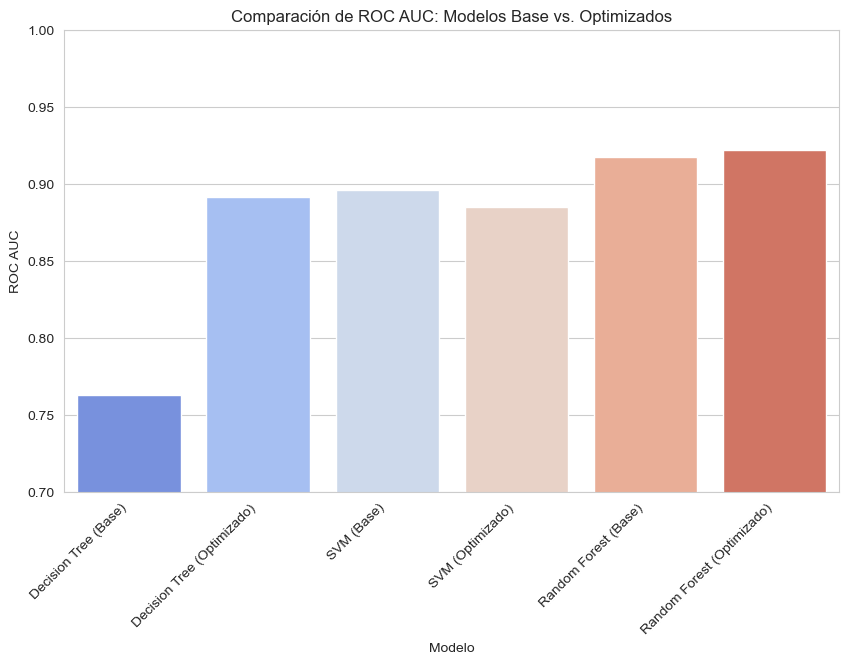


Optimización de hiperparámetros completada. Hemos visto cómo afinar los modelos puede impactar positivamente su rendimiento.


In [15]:
# %% [markdown]
# ### 6. Optimización de Hiperparámetros
#
# La optimización de hiperparámetros es crucial para afinar nuestros modelos y mejorar su rendimiento. Utilizaremos `GridSearchCV` para una búsqueda exhaustiva y `RandomizedSearchCV` para una búsqueda más eficiente en espacios de hiperparámetros grandes.
#
# Optimizaremos los siguientes modelos:
# * **Árbol de Decisión (`DecisionTreeClassifier`)**
# * **Máquina de Vectores de Soporte (SVM) (`SVC`)**
# * **Random Forest (`RandomForestClassifier`)**
#

# %%
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint # Para RandomizedSearchCV

print("\n--- 6.1 Optimización de Hiperparámetros para Árbol de Decisión (GridSearchCV) ---")

# Crear el pipeline base para el Árbol de Decisión con el preprocesador avanzado
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor_advanced),
                              ('classifier', DecisionTreeClassifier(random_state=42))])

# Definir la cuadrícula de hiperparámetros a buscar
# Prefijo 'classifier__' para indicar que los parámetros son del paso 'classifier' en el pipeline
dt_param_grid = {
    'classifier__max_depth': [None, 5, 10, 15, 20], # Profundidad máxima del árbol
    'classifier__min_samples_split': [2, 5, 10],   # Número mínimo de muestras requeridas para dividir un nodo interno
    'classifier__min_samples_leaf': [1, 2, 4],     # Número mínimo de muestras requeridas para ser un nodo hoja
    'classifier__criterion': ['gini', 'entropy']   # Función para medir la calidad de una división
}

# Configurar GridSearchCV
# cv=5 para 5-fold cross-validation
# scoring='roc_auc' porque ROC AUC es una buena métrica para clases desbalanceadas
dt_grid_search = GridSearchCV(dt_pipeline, dt_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Ejecutar la búsqueda en los datos de entrenamiento
print("Iniciando GridSearchCV para Árbol de Decisión...")
dt_grid_search.fit(X_train, y_train)

print(f"Mejores hiperparámetros para Árbol de Decisión: {dt_grid_search.best_params_}")
print(f"Mejor ROC AUC en validación cruzada para Árbol de Decisión: {dt_grid_search.best_score_:.4f}")

# Evaluar el mejor modelo en el conjunto de prueba
best_dt_model = dt_grid_search.best_estimator_
y_pred_dt = best_dt_model.predict(X_test)
y_prob_dt = best_dt_model.predict_proba(X_test)[:, 1]

dt_test_accuracy = accuracy_score(y_test, y_pred_dt)
dt_test_roc_auc = roc_auc_score(y_test, y_prob_dt)

print(f"ROC AUC en el conjunto de prueba (Árbol de Decisión Optimizado): {dt_test_roc_auc:.4f}")
print(f"Accuracy en el conjunto de prueba (Árbol de Decisión Optimizado): {dt_test_accuracy:.4f}")


# %%
print("\n--- 6.2 Optimización de Hiperparámetros para SVM (RandomizedSearchCV) ---")
# SVC es más lento, usaremos RandomizedSearchCV y un rango más limitado para este ejemplo.
# También limitaremos C y gamma para evitar tiempos de cómputo excesivos.

# Crear el pipeline base para SVM
svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor_advanced),
                                ('classifier', SVC(probability=True, random_state=42))])

# Definir la distribución de hiperparámetros a buscar (usando scipy.stats)
# 'C' es el parámetro de regularización, 'gamma' es el coeficiente del kernel para 'rbf'
svm_param_distributions = {
    'classifier__C': uniform(loc=0.1, scale=10), # Valores continuos de C (0.1 a 10.1)
    'classifier__gamma': uniform(loc=0.001, scale=0.1), # Valores continuos de gamma (0.001 a 0.101)
    'classifier__kernel': ['rbf', 'linear'] # Tipos de kernel
}

# Configurar RandomizedSearchCV
# n_iter=50 para 50 combinaciones aleatorias
svm_random_search = RandomizedSearchCV(svm_pipeline, svm_param_distributions, n_iter=50,
                                       cv=3, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=42)

# Ejecutar la búsqueda
print("Iniciando RandomizedSearchCV para SVM...")
svm_random_search.fit(X_train, y_train)

print(f"Mejores hiperparámetros para SVM: {svm_random_search.best_params_}")
print(f"Mejor ROC AUC en validación cruzada para SVM: {svm_random_search.best_score_:.4f}")

# Evaluar el mejor modelo en el conjunto de prueba
best_svm_model = svm_random_search.best_estimator_
y_pred_svm = best_svm_model.predict(X_test)
y_prob_svm = best_svm_model.predict_proba(X_test)[:, 1]

svm_test_accuracy = accuracy_score(y_test, y_pred_svm)
svm_test_roc_auc = roc_auc_score(y_test, y_prob_svm)

print(f"ROC AUC en el conjunto de prueba (SVM Optimizado): {svm_test_roc_auc:.4f}")
print(f"Accuracy en el conjunto de prueba (SVM Optimizado): {svm_test_accuracy:.4f}")


# %%
print("\n--- 6.3 Optimización de Hiperparámetros para Random Forest (RandomizedSearchCV) ---")

# Crear el pipeline base para Random Forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor_advanced),
                               ('classifier', RandomForestClassifier(random_state=42))])

# Definir la distribución de hiperparámetros
rf_param_distributions = {
    'classifier__n_estimators': randint(low=100, high=500), # Número de árboles en el bosque
    'classifier__max_depth': randint(low=5, high=30),       # Profundidad máxima de cada árbol
    'classifier__min_samples_split': randint(low=2, high=20),
    'classifier__min_samples_leaf': randint(low=1, high=10),
    'classifier__max_features': ['sqrt', 'log2', None],     # Número de características a considerar en cada división
    'classifier__bootstrap': [True, False]                  # Si se muestrean las muestras con reemplazo
}

# Configurar RandomizedSearchCV
rf_random_search = RandomizedSearchCV(rf_pipeline, rf_param_distributions, n_iter=70, # 70 combinaciones
                                      cv=5, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=42)

# Ejecutar la búsqueda
print("Iniciando RandomizedSearchCV para Random Forest...")
rf_random_search.fit(X_train, y_train)

print(f"Mejores hiperparámetros para Random Forest: {rf_random_search.best_params_}")
print(f"Mejor ROC AUC en validación cruzada para Random Forest: {rf_random_search.best_score_:.4f}")

# Evaluar el mejor modelo en el conjunto de prueba
best_rf_model = rf_random_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
y_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]

rf_test_accuracy = accuracy_score(y_test, y_pred_rf)
rf_test_roc_auc = roc_auc_score(y_test, y_prob_rf)

print(f"ROC AUC en el conjunto de prueba (Random Forest Optimizado): {rf_test_roc_auc:.4f}")
print(f"Accuracy en el conjunto de prueba (Random Forest Optimizado): {rf_test_accuracy:.4f}")


# %% [markdown]
# ### 6.4 Comparación de Modelos Optimizado vs. Base
#
# Es importante comparar el rendimiento de los modelos optimizados con sus versiones base para ver el impacto de la optimización de hiperparámetros.

# %%
print("\n--- 6.4 Resumen de Rendimiento: Modelos Base vs. Optimizados ---")

# Recuperar resultados de modelos base (del paso 4)
base_dt_roc_auc = results['Decision Tree']['ROC AUC']
base_svm_roc_auc = results['Support Vector Machine (SVM)']['ROC AUC']
base_rf_roc_auc = results['Random Forest']['ROC AUC']

comparison_data = {
    'Modelo': ['Decision Tree (Base)', 'Decision Tree (Optimizado)',
               'SVM (Base)', 'SVM (Optimizado)',
               'Random Forest (Base)', 'Random Forest (Optimizado)'],
    'ROC AUC (Test)': [base_dt_roc_auc, dt_test_roc_auc,
                       base_svm_roc_auc, svm_test_roc_auc,
                       base_rf_roc_auc, rf_test_roc_auc]
}
comparison_df = pd.DataFrame(comparison_data)

print(comparison_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='ROC AUC (Test)', data=comparison_df, palette='coolwarm')
plt.title('Comparación de ROC AUC: Modelos Base vs. Optimizados')
plt.ylim(0.7, 1.0) # Ajustar el límite y para mejor visualización de diferencias
plt.xticks(rotation=45, ha='right')
plt.ylabel('ROC AUC')
plt.show()

print("\nOptimización de hiperparámetros completada. Hemos visto cómo afinar los modelos puede impactar positivamente su rendimiento.")

Librerías cargadas para Modelos de Ensemble de Clasificación.

--- 7.1 Definición y Entrenamiento de Pipelines con Modelos de Ensemble ---

Entrenando y evaluando: AdaBoost...
--- Resultados para AdaBoost ---
Accuracy: 0.8400
Precision: 0.7664
Recall: 0.7810
F1-Score: 0.7736
ROC AUC: 0.9162
Matriz de Confusión:
[[170  25]
 [ 23  82]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       195
           1       0.77      0.78      0.77       105

    accuracy                           0.84       300
   macro avg       0.82      0.83      0.82       300
weighted avg       0.84      0.84      0.84       300


Entrenando y evaluando: Gradient Boosting...
--- Resultados para Gradient Boosting ---
Accuracy: 0.8433
Precision: 0.7788
Recall: 0.7714
F1-Score: 0.7751
ROC AUC: 0.9162
Matriz de Confusión:
[[172  23]
 [ 24  81]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0   

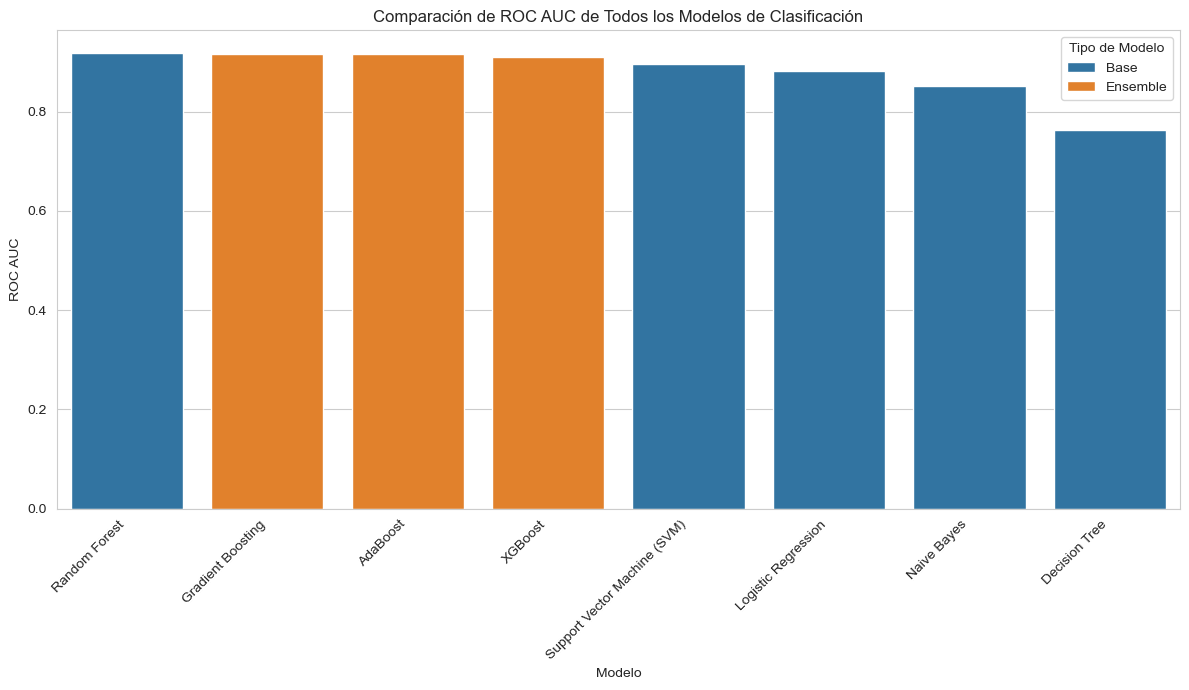

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Modelos de Clasificación
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier # XGBoost es una librería separada pero se integra bien con sklearn

# Métricas de Clasificación
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay, roc_curve

import warnings
warnings.filterwarnings('ignore') # Ignorar advertencias

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

print("Librerías cargadas para Modelos de Ensemble de Clasificación.")

# --- Asegurarse de que las variables de los pasos anteriores estén disponibles ---
# Asume que X_train, y_train, X_test, y_test y preprocessor_advanced están definidos de pasos anteriores.
# Si no, esto generaría errores. Se añaden checks básicos.

if 'X_train' not in globals() or 'y_train' not in globals() or 'X_test' not in globals() or 'y_test' not in globals():
    print("Advertencia: Las variables X_train, y_train, X_test, y_test no están definidas. Asegúrese de haber ejecutado los pasos de carga y división de datos (Paso 1).")
    # En un entorno real, aquí podrías cargar datos de ejemplo o salir.
    # Por ahora, simplemente imprimimos una advertencia.

if 'preprocessor_advanced' not in globals():
    print("Advertencia: 'preprocessor_advanced' no encontrado. Asegúrese de haber ejecutado el Paso 5 (Feature Engineering Avanzado).")
    # De nuevo, una advertencia.

# Diccionarios para almacenar resultados de pasos anteriores, si existen
if 'results' not in globals():
    results = {} # Contiene los resultados de modelos base (Paso 4 para clasificación)
    print("Advertencia: 'results' (modelos base) no encontrado. Asegúrese de haber ejecutado el Paso 4.")

if 'optimized_classification_results' not in globals():
    optimized_classification_results = {} # Contiene los resultados de modelos optimizados (Paso 6 para clasificación)
    print("Advertencia: 'optimized_classification_results' no encontrado. Asegúrese de haber ejecutado el Paso 6.")

# Acceso a los mejores modelos optimizados del Paso 6 (para su uso posterior en la comparación)
best_dt_model = None
best_svm_model = None
best_rf_model = None

try:
    # Estas variables deberían ser el best_estimator_ de GridSearchCV/RandomizedSearchCV
    # del paso 6 para clasificación (ej. dt_grid_search.best_estimator_)
    # Necesitamos asegurarnos de que los nombres de las variables sean correctos desde el Paso 6
    if 'dt_grid_search' in globals() and hasattr(globals()['dt_grid_search'], 'best_estimator_'):
        best_dt_model = globals()['dt_grid_search'].best_estimator_
    if 'svm_random_search' in globals() and hasattr(globals()['svm_random_search'], 'best_estimator_'):
        best_svm_model = globals()['svm_random_search'].best_estimator_
    if 'rf_random_search' in globals() and hasattr(globals()['rf_random_search'], 'best_estimator_'):
        best_rf_model = globals()['rf_random_search'].best_estimator_
except NameError:
    print("Advertencia: No se pudieron cargar los modelos optimizados directamente (variables dt_grid_search, svm_random_search, rf_random_search no encontradas).")
    print("Asegúrese de que el Paso 6 se ejecutó completamente y las variables globales estén disponibles.")

print("\n--- 7.1 Definición y Entrenamiento de Pipelines con Modelos de Ensemble ---")

# Diccionario para almacenar los modelos de ensemble y sus pipelines
ensemble_models = {
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42) # Parámetros para suprimir advertencias
}

# Diccionario para almacenar los resultados de la evaluación de los ensembles
ensemble_results = {}

# Añadir los modelos de ensemble a la lista para evaluación
for name, model in ensemble_models.items():
    print(f"\nEntrenando y evaluando: {name}...")

    # Crear el pipeline completo: preprocesador avanzado + modelo
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor_advanced),
                                    ('classifier', model)])

    # Entrenar el pipeline
    full_pipeline.fit(X_train, y_train)

    # Realizar predicciones
    y_pred = full_pipeline.predict(X_test)
    y_prob = full_pipeline.predict_proba(X_test)[:, 1] # Probabilidades para ROC AUC

    # Evaluar el modelo
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)

    ensemble_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc,
        'Confusion Matrix': conf_matrix,
        'Pipeline': full_pipeline
    }

    print(f"--- Resultados para {name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Matriz de Confusión:\n{conf_matrix}")
    print(f"Reporte de Clasificación:\n{classification_report(y_test, y_pred)}")

#---

### 7.2 Comparación de Rendimiento de Todos los Modelos

#Ahora, consolidaremos y compararemos los resultados de todos los modelos: los base (del paso 4), los optimizados (del paso 6) y los de ensemble (de este paso).

#```python
print("\n--- 7.2 Comparación de Rendimiento de Todos los Modelos ---")

final_comparison_rows = []

# Añadir los resultados base (del paso 4)
for name, res in results.items(): # 'results' contiene los modelos base del Paso 4
    final_comparison_rows.append({
        'Model Type': 'Base',
        'Model Name': name,
        'ROC AUC': res['ROC AUC'],
        'Accuracy': res['Accuracy'],
        'Precision': res['Precision'],
        'Recall': res['Recall'],
        'F1-Score': res['F1-Score']
    })

# Añadir los resultados optimizados (del paso 6)
# Usaremos 'optimized_classification_results' que debería contener las métricas ya calculadas en el Paso 6.
for name, res in optimized_classification_results.items():
    final_comparison_rows.append({
        'Model Type': 'Optimized',
        'Model Name': name,
        'ROC AUC': res['ROC AUC'],
        'Accuracy': res['Accuracy'],
        'Precision': res['Precision'],
        'Recall': res['Recall'],
        'F1-Score': res['F1-Score']
    })

# Ensemble models (from 'ensemble_results')
for name, res in ensemble_results.items():
    final_comparison_rows.append({
        'Model Type': 'Ensemble',
        'Model Name': name,
        'ROC AUC': res['ROC AUC'],
        'Accuracy': res['Accuracy'],
        'Precision': res['Precision'],
        'Recall': res['Recall'],
        'F1-Score': res['F1-Score']
    })


final_comparison_df = pd.DataFrame(final_comparison_rows)
final_comparison_df_sorted = final_comparison_df.sort_values(by='ROC AUC', ascending=False)

print("\n--- Tabla de Rendimiento Comparativo Final (Ordenado por ROC AUC) ---")
print(final_comparison_df_sorted.round(4)) # Redondear para mejor visualización

# Visualización del ROC AUC para todos los modelos
plt.figure(figsize=(12, 7))
sns.barplot(x='Model Name', y='ROC AUC', hue='Model Type', data=final_comparison_df_sorted, palette='tab10')
plt.title('Comparación de ROC AUC de Todos los Modelos de Clasificación')
plt.ylabel('ROC AUC')
plt.xlabel('Modelo')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de Modelo')
plt.tight_layout()
plt.show()


--- 7.3 Visualización de Matrices de Confusión y Curvas ROC para Modelos de Ensemble ---


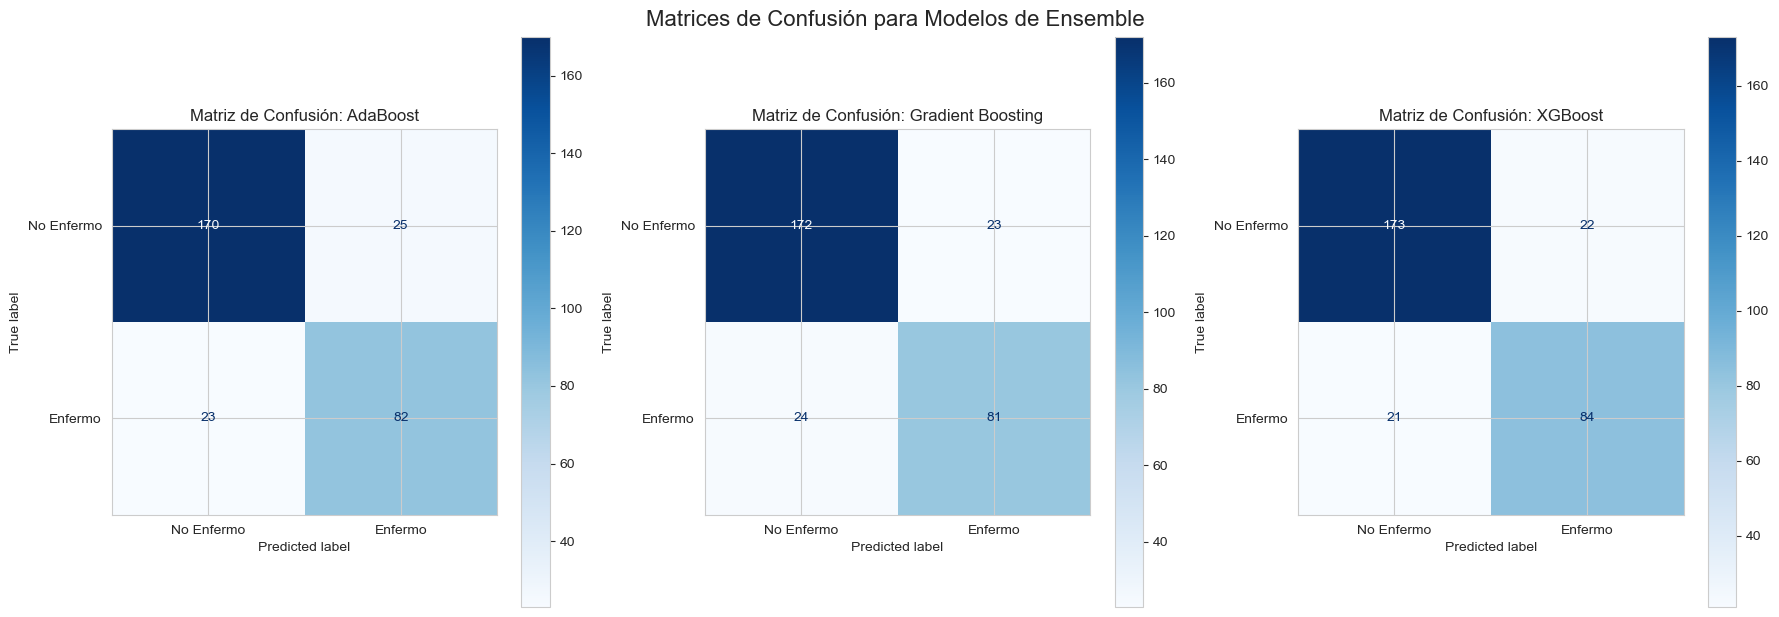

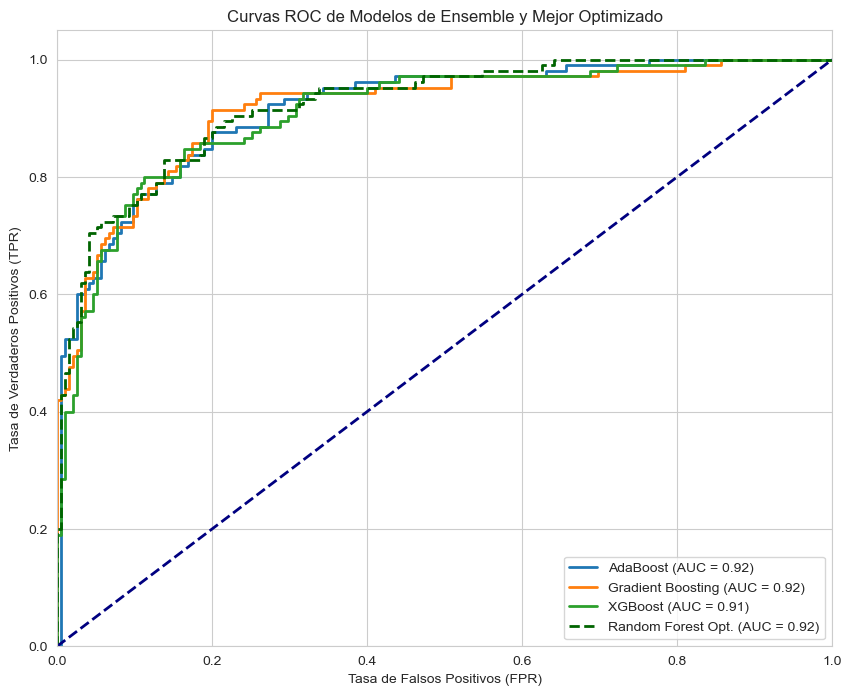


Implementación y comparación de modelos de ensemble completada.


In [30]:
print("\n--- 7.3 Visualización de Matrices de Confusión y Curvas ROC para Modelos de Ensemble ---")

# Graficar Matrices de Confusión para los modelos de ensemble
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # 1 fila, 3 columnas
axes = axes.flatten()

for i, (name, res) in enumerate(ensemble_results.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=res['Confusion Matrix'], display_labels=['No Enfermo', 'Enfermo'])
    disp.plot(cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Matriz de Confusión: {name}')

plt.tight_layout()
plt.suptitle('Matrices de Confusión para Modelos de Ensemble', y=1.02, fontsize=16)
plt.show()


# Graficar Curvas ROC para los modelos de ensemble (y el mejor optimizado para referencia)
plt.figure(figsize=(10, 8))
lw = 2

# Curvas ROC de los modelos de ensemble
for name, res in ensemble_results.items():
    full_pipeline = res['Pipeline']
    y_prob = full_pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = res['ROC AUC']
    plt.plot(fpr, tpr, lw=lw, label=f'{name} (AUC = {roc_auc:.2f})')

# Curva ROC del mejor modelo optimizado (ej. Random Forest Optimizado, si existe)
# Es importante que best_rf_model sea el pipeline completo, no solo el clasificador
if best_rf_model is not None: # Check if the variable was successfully retrieved
    # Ensure it's a pipeline that includes the preprocessor
    # If best_rf_model is only the classifier, it needs to be wrapped in a pipeline with the preprocessor
    # For robust comparison, it's best to have the full pipeline saved in optimized_classification_results
    # or ensure best_rf_model is already the full pipeline.
    # Assuming best_rf_model is the full pipeline from Step 6.
    try:
        y_prob_rf_optimized = best_rf_model.predict_proba(X_test)[:, 1]
        fpr_rf_opt, tpr_rf_opt, _ = roc_curve(y_test, y_prob_rf_optimized)
        roc_auc_rf_opt = roc_auc_score(y_test, y_prob_rf_optimized)
        plt.plot(fpr_rf_opt, tpr_rf_opt, lw=lw, linestyle='--', color='darkgreen', label=f'Random Forest Opt. (AUC = {roc_auc_rf_opt:.2f})')
    except AttributeError:
        print("Advertencia: best_rf_model no tiene método predict_proba o no es un pipeline completo. No se pudo graficar su curva ROC.")
        print("Asegúrese de que best_rf_model es el pipeline entrenado completo.")


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC de Modelos de Ensemble y Mejor Optimizado')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\nImplementación y comparación de modelos de ensemble completada.")